In [2]:
!pip install -U learn2learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 86.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo unzip ./drive/MyDrive/CHASEDB -d chase

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import learn2learn as l2l
from learn2learn.data.transforms import FusedNWaysKShots, RemapLabels, ConsecutiveLabels

from statistics import mean
from copy import deepcopy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


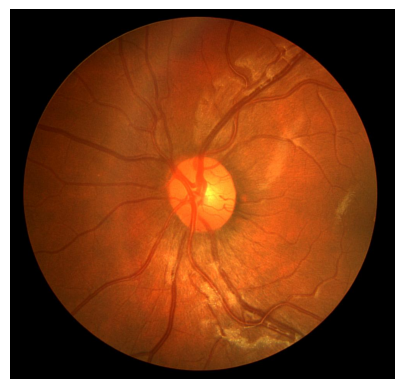

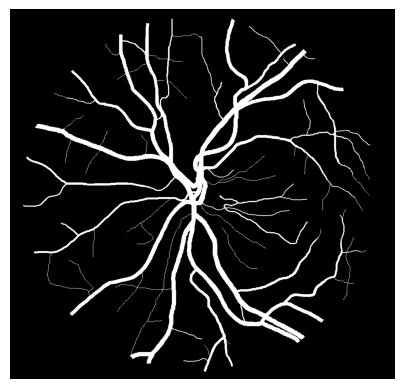

In [2]:
import matplotlib.image as mpimg

image_path = "./chase/Image_02L.jpg"
img = mpimg.imread(image_path)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

image_path = "./chase/Image_02L_1stHO.png"
img = mpimg.imread(image_path)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [3]:
import matplotlib.image as mpimg

def visualize_img_from_path(path):
  image_path = path
  img = mpimg.imread(image_path)

  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


def visualize_img(image, mask):
    # Convert image and mask tensors to numpy arrays
    image_np = image.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    mask_np = mask.numpy().squeeze()  # Remove the channel dimension if it's one

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Display the image
    axes[0].imshow(image_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms

        self.image_paths = []
        self.mask_paths = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                image_filename = filename
                mask_filename = filename.replace(".jpg", "_1stHO.png")
            elif filename.endswith(".tif"):
                image_filename = filename
                mask_filename = filename.replace("_training.tif", "_manual1.gif")
            else:
                continue

            self.image_paths.append(os.path.join(image_dir, image_filename))
            self.mask_paths.append(os.path.join(mask_dir, mask_filename))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Apply transformations if any
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)


        return (image, mask)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image_dir_dataset1 = './chase'
mask_dir_dataset1 = './chase'
dataset1 = SegmentationDataset(image_dir_dataset1, mask_dir_dataset1, transforms=transform)

image_dir_dataset2 = './drive_dataset/DRIVE/training/images'
mask_dir_dataset2 = './drive_dataset/DRIVE/training/1st_manual'
dataset2 = SegmentationDataset(image_dir_dataset2, mask_dir_dataset2, transforms=transform)



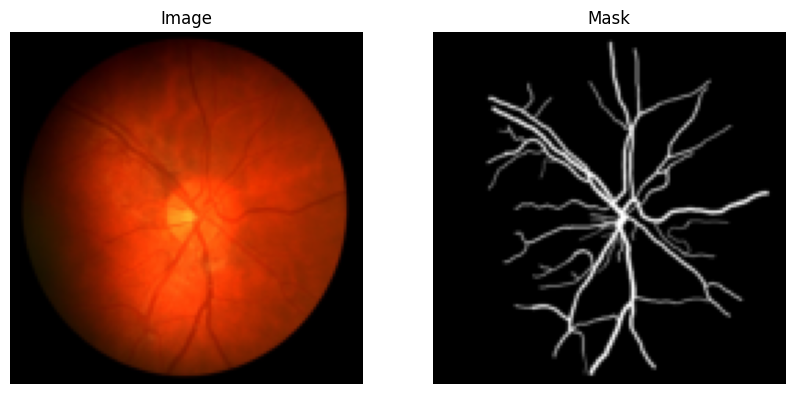

In [5]:
image, mask = dataset1[0] # Get the first image and mask from dataset1
visualize_img(image,mask)

In [6]:
# batch_size = 32
# dataloader_dataset1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
# dataloader_dataset2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [7]:
# for images,mask in dataloader_dataset1:
#   print(images[0].shape)
#   print(mask[0].shape)
#   break

In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()
#         # Encoder
#         self.enc_conv1 = self.conv_block(in_channels, 64)
#         self.enc_conv2 = self.conv_block(64, 128)

#         # Decoder
#         self.dec_conv1 = self.conv_block(128, 64)

#         self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

#         self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x):
#         # Add an extra dimension for the batch size if it's missing
#         if len(x.shape) == 3:
#             x = x.unsqueeze(0)

#         # Encoder
#         enc1 = self.enc_conv1(x)
#         enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))

#         # Decoder
#         dec1 = self.dec_conv1(torch.cat([enc2, self.upconv1(F.max_pool2d(enc1, kernel_size=2, stride=2))], 1))

#         return self.final_conv(dec1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )


In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes):
#         super().__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
#         self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
#         self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
#         self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
#         self.up1 = nn.Sequential(nn.ConvTranspose2d(1536, 512, kernel_size=2, stride=2), DoubleConv(512, 512))
#         self.up2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, kernel_size=2, stride=2), DoubleConv(512, 256))
#         self.up3 = nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2), DoubleConv(256, 128))
#         self.up4 = nn.Sequential(nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2), DoubleConv(128, 64))
#         self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(torch.cat([x4, F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)], dim=1))
#         x = self.up2(torch.cat([x3, F.interpolate(x, size=x3.size()[2:], mode='bilinear', align_corners=True)], dim=1))
#         x = self.up3(torch.cat([x2, F.interpolate(x, size=x2.size()[2:], mode='bilinear', align_corners=True)], dim=1))
#         x = self.up4(torch.cat([x1, F.interpolate(x, size=x1.size()[2:], mode='bilinear', align_corners=True)], dim=1))
#         logits = self.outc(x)
#         return logits

In [10]:
from torch.utils.data import ConcatDataset,random_split
concat_dataset = ConcatDataset([dataset1, dataset2])
#split the dataset into train test and validation
train_size = int(0.7 * len(concat_dataset))
val_size = int(0.1 * len(concat_dataset))
test_size = len(concat_dataset) - train_size - val_size
train_dataset, valid_dataset, test_dataset = random_split(concat_dataset, [train_size, val_size, test_size])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:

# def accuracy(predictions, targets):
#     predictions = predictions.argmax(dim=1).view(targets.shape)
#     return (predictions == targets).sum().float() / targets.size(0)


# def fast_adapt(batch,
#                learner,
#                features,
#                loss,
#                adaptation_steps,
#                shots,
#                ways,
#                device=None):

#     data, labels = batch
#     data, labels = data.to(device), labels.to(device)
#     data = features(data)

#     # Separate data into adaptation/evaluation sets
#     adaptation_indices = np.zeros(data.size(0), dtype=bool)
#     adaptation_indices[np.arange(shots*ways) * 2] = True
#     evaluation_indices = torch.from_numpy(~adaptation_indices)
#     adaptation_indices = torch.from_numpy(adaptation_indices)
#     adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
#     evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

#     for step in range(adaptation_steps):
#         train_error = loss(learner(adaptation_data), adaptation_labels)
#         learner.adapt(train_error)

#     predictions = learner(evaluation_data)
#     valid_error = loss(predictions, evaluation_labels)
#     valid_accuracy = accuracy(predictions, evaluation_labels)
#     return valid_error, valid_accuracy

In [13]:
# import random
# from typing import List, Tuple
# import learn2learn as l2l

# class SegmentationNWaysKShots:
#     """
#     A transformation that creates few-shot tasks for image segmentation.

#     Args:
#         dataset (MetaDataset): The dataset to create tasks from.
#         n (int): The number of classes (ways) in each task.
#         k (int): The number of samples per class (shots).
#         seed (int, optional): The random seed to use.

#     Example:
#         >>> dataset = YourImageSegmentationDataset(root="/path/to/data")
#         >>> dataset = l2l.data.MetaDataset(dataset)
#         >>> transform = SegmentationNWaysKShots(dataset, n=5, k=2)
#         >>> task = transform(dataset.sample_indices, dataset.indices_to_data)
#         >>> for image, mask in task:
#         ...     # Do something with the image and mask
#         ...     pass
#     """
#     def __init__(self, dataset, n: int, k: int, seed: int = None):
#         if not isinstance(dataset, MetaDataset):
#             dataset = MetaDataset(dataset)
#         self.dataset = dataset
#         self.n = min(n, len(self.dataset.sample_indices) // k)
#         self.k = k
#         self.seed = seed
#         self.random = random.Random(seed)

#     def __call__(self, sample_indices, indices_to_data):
#         indices = self.random.sample(sample_indices, self.n * self.k)
#         data = [(indices_to_data[idx]) for idx in indices]
#         return data

In [14]:
# class LoadData:
#     """
#     A transformation that loads the data for a given task description.

#     Args:
#         dataset (MetaDataset): The dataset to load data from.

#     Example:
#         >>> dataset = YourImageSegmentationDataset(root="/path/to/data")
#         >>> dataset = l2l.data.MetaDataset(dataset)
#         >>> transform = LoadData(dataset)
#         >>> task_description = [({"index": 0}, []), ({"index": 1}, [])]
#         >>> task_data = transform(task_description)
#         >>> for image, mask in task_data:
#         ...     # Do something with the image and mask
#         ...     pass
#     """
#     def __init__(self, dataset):
#         self.dataset = dataset

#     def __call__(self, task_description):
#         data = []
#         for data_description in task_description:
#             index = data_description["index"]
#             image, mask = self.dataset[index]
#             data.append((image, mask))
#         return data

In [15]:
# class SegmentationTaskset(TaskDataset):
#     def __init__(self, dataset, task_transforms=None, num_tasks=-1, task_collate=None):
#         if not isinstance(dataset, MetaDataset):
#             dataset = MetaDataset(dataset)

#         super().__init__(
#             dataset=dataset,
#             task_transforms=task_transforms,
#             num_tasks=num_tasks,
#             task_collate=task_collate,
#         )

#     def sample(self, task_description):
#         task_data = []
#         for task_transform in self.task_transforms:
#             task_data = task_transform(self.dataset.sample_indices, self.dataset.indices_to_data)
#         if self.task_collate is None:
#             return task_data
#         else:
#             images, masks = zip(*task_data)
#             images = self.task_collate(images)
#             masks = self.task_collate(masks)
#             return images, masks

#     def sample_batch(self, batch_size):
#         task_data_batch = []
#         task_labels_batch = []
#         for _ in range(batch_size):
#             task_data, task_labels = self.sample(None)
#             task_data_batch.append(task_data)
#             task_labels_batch.append(task_labels)
#         return task_data_batch, task_labels_batch

#     def sample_task_description(self):
#         return None

In [16]:
import random
from typing import List, Tuple, Dict, Any
import os
import pickle
import random
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset
import learn2learn as l2l
from typing import Callable, List, Dict, Any
from torch.utils.data import default_collate

class TaskDataset:
    """
    Creates a set of tasks from a given Dataset.

    In addition to the Dataset, TaskDataset accepts a list of task transformations (`task_transforms`)
    which define the kind of tasks sampled from the dataset.

    The tasks are lazily sampled upon indexing (or calling the `.sample()` method), and their
    descriptions cached for later use.

    If `num_tasks` is -1, the TaskDataset will not cache task descriptions and instead continuously resample
    new ones.

    In this case, the length of the TaskDataset is set to 1.

    For more information on tasks and task descriptions, please refer to the
    documentation of task transforms.

    Args:
        dataset (Dataset): Dataset of data to compute tasks.
        task_transforms (list, optional): List of task transformations.
        num_tasks (int, optional): Number of tasks to generate. Default is -1 (infinity).
        task_collate (callable, optional): A function to collate the task data. Default is `default_collate`.

    Example:
        >>> from your_module import MetaDataset
        >>> dataset = YourImageSegmentationDataset(root="/path/to/data")
        >>> dataset = MetaDataset(dataset)
        >>> transforms = [
        ...     SegmentationNWaysKShots(dataset, n=5, k=2),
        ...     LoadData(dataset),
        ... ]
        >>> taskset = TaskDataset(dataset, transforms, num_tasks=20000)
        >>> for task in taskset:
        ...     X, y = task
        ...     # Do something with X and y
        ...     pass
    """

    def __init__(self, dataset, task_transforms: List = None, num_tasks: int = -1, task_collate: Callable = None):
        if not isinstance(dataset, MetaDataset):
            dataset = MetaDataset(dataset)

        if task_transforms is None:
            task_transforms = []

        if task_collate is None:
            task_collate = default_collate

        if num_tasks < -1 or num_tasks == 0:
            raise ValueError('num_tasks needs to be -1 (infinity) or positive.')

        self.dataset = dataset
        self.num_tasks = num_tasks
        self.task_transforms = task_transforms
        self.sampled_descriptions = {}  # Maps indices to tasks' description dict
        self.task_collate = task_collate
        self._task_id = 0

    def sample_task_description(self) -> List[Dict[str, Any]]:
        """
        Samples a new task description.
        """
        description = []

        if callable(self.task_transforms):
            return self.task_transforms(description)

        for transform in self.task_transforms:
            description = transform(description)
        print("IN TASKDATASET CLASS \n")
        print(f"Description :{description}")
        print("\n#######\n")
        return description

    def get_task(self, task_description: List[Dict[str, Any]]):
        """
        Given a task description, creates the corresponding batch of data.
        """
        all_data = []
        for data_description in task_description:
            data = self.dataset[data_description['index']]
            for transform in data_description['transforms']:
                data = transform(data)
            all_data.append(data)
        print("IN TASKDATASET CLASS \n")
        print(f"All_data :{self.task_collate(all_data)}")
        print("\n#######\n")
        return self.task_collate(all_data)

    def sample(self):
        """
        Randomly samples a task from the TaskDataset.

        Example:
            >>> X, y = taskset.sample()
        """
        if self.num_tasks == -1:
            return self.get_task(self.sample_task_description())
        else:
            i = random.randint(0, len(self) - 1)
            print("IN TASKDATASET CLASS \n")
            print(f"Sampled :{self[i]}")
            print("\n#######\n")
            return self[i]

    def __len__(self):
        if self.num_tasks == -1:
            # Ok to return 1, since __iter__ will run forever
            # and __getitem__ will always resample.
            return 1
        return self.num_tasks

    def __getitem__(self, i):
        if self.num_tasks == -1:
            return self.get_task(self.sample_task_description())

        if i not in self.sampled_descriptions:
            self.sampled_descriptions[i] = self.sample_task_description()

        task_description = self.sampled_descriptions[i]
        return self.get_task(task_description)

    def __iter__(self):
        self._task_id = 0
        return self

    def __next__(self):
        if self.num_tasks == -1:
            return self.get_task(self.sample_task_description())
        if self._task_id < self.num_tasks:
            task = self[self._task_id]
            self._task_id += 1
            return task
        else:
            raise StopIteration

    def __add__(self, other):
        msg = 'Adding datasets not yet supported for TaskDatasets.'
        raise NotImplementedError(msg)

class MetaDataset(Dataset):
    """
    **Description**

    Wraps an image segmentation dataset to enable fast indexing of samples.

    This class exposes two attributes specific to the wrapped dataset:

    * `sample_indices`: a list of all sample indices.
    * `indices_to_data`: maps a sample index to its corresponding image and mask data.

    Those attributes can be used to quickly create few-shot segmentation tasks.
    They can be passed as arguments upon instantiation, or automatically built on-the-fly.
    If the wrapped dataset has an attribute `_bookkeeping_path`, then the built attributes will be cached on disk and reloaded upon the next instantiation.
    This caching strategy is useful for large datasets where the first instantiation can take several hours.

    Note that if only `sample_indices` or `indices_to_data` is provided, this class builds the other one from it.

    **Arguments**

    * **dataset** (Dataset) -  A torch Dataset.
    * **sample_indices** (list, **optional**, default=None) -  A list of sample indices.
    * **indices_to_data** (dict, **optional**, default=None) -  A dictionary mapping sample indices to their corresponding image and mask data.

    **Example**
    ~~~python
    dataset = YourImageSegmentationDataset(root="/path/to/data")
    dataset = l2l.data.MetaDataset(dataset)
    ~~~
    """

    def __init__(self, dataset, sample_indices=None, indices_to_data=None):
        if not isinstance(dataset, Dataset):
            raise TypeError("MetaDataset only accepts a torch dataset as input")

        self.dataset = dataset

        if hasattr(dataset, '_bookkeeping_path'):
            self.load_bookkeeping(dataset._bookkeeping_path)
        else:
            self.create_bookkeeping(sample_indices=sample_indices, indices_to_data=indices_to_data)

    def __getitem__(self, item):
        return self.indices_to_data[item]

    def __len__(self):
        return len(self.sample_indices)

    def create_bookkeeping(self, sample_indices=None, indices_to_data=None):
        """
        Iterates over the entire dataset and creates a map of indices to data.
        """

        assert hasattr(self.dataset, '__getitem__'), 'Requires iterable-style dataset.'

        # Bootstrap from arguments
        if sample_indices is not None:
            indices_to_data = {idx: self.dataset[idx] for idx in sample_indices}
        elif indices_to_data is not None:
            sample_indices = list(indices_to_data.keys())
        else:  # Create from scratch
            sample_indices = []
            indices_to_data = {}
            for i in range(len(self.dataset)):
                sample_indices.append(i)
                image, mask = self.dataset[i]
                indices_to_data[i] = (image, mask)

        self.sample_indices = sample_indices
        self.indices_to_data = indices_to_data

        self._bookkeeping = {
            'sample_indices': self.sample_indices,
            'indices_to_data': self.indices_to_data,
        }

    def load_bookkeeping(self, path):
        if not os.path.exists(path):
            self.create_bookkeeping()
            self.serialize_bookkeeping(path)
        else:
            with open(path, 'rb') as f:
                self._bookkeeping = pickle.load(f)
            self.sample_indices = self._bookkeeping['sample_indices']
            self.indices_to_data = self._bookkeeping['indices_to_data']

    def serialize_bookkeeping(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self._bookkeeping, f, protocol=-1)

class SegmentationNWaysKShots:
    """
    A transformation that creates few-shot tasks for image segmentation.

    Args:
        dataset (MetaDataset): The dataset to create tasks from.
        n (int): The number of classes (ways) in each task.
        k (int): The number of samples per class (shots).
        seed (int, optional): The random seed to use.

    Example:
        >>> dataset = YourImageSegmentationDataset(root="/path/to/data")
        >>> dataset = MetaDataset(dataset)
        >>> transform = SegmentationNWaysKShots(dataset, n=5, k=2)
        >>> task = transform(dataset)
        >>> for image, mask in task:
        ...     # Do something with the image and mask
        ...     pass
    """
    def __init__(self, dataset, n: int, k: int, seed: int = None):
        if not isinstance(dataset, MetaDataset):
            dataset = MetaDataset(dataset)
        self.dataset = dataset
        self.n = min(n, len(self.dataset.sample_indices) // k)
        self.k = k
        self.seed = seed
        self.random = random.Random(seed)

    def __call__(self, dataset):
        indices = self.random.sample(dataset.sample_indices, self.n * self.k)
        # Adjusted to return a list of dictionaries with "index" keys
        return [{"index": idx} for idx in indices]

    def generate_task_description(self):
        """
        Generates a task description as a list of dictionaries with "index" keys.
        """
        indices = self.random.sample(self.dataset.sample_indices, self.n * self.k)
        return [{"index": idx} for idx in indices]

class LoadData:
    """
    A transformation that loads the data for a given task description.

    Args:
        dataset (MetaDataset): The dataset to load data from.
        task_description (list): A list of dictionaries describing the task.

    Example:
        >>> dataset = YourImageSegmentationDataset(root="/path/to/data")
        >>> dataset = MetaDataset(dataset)
        >>> transform = LoadData(dataset, task_description=[{"index": 0}, {"index": 1}])
        >>> task_data = transform()
        >>> for image, mask in task_data:
        ...     # Do something with the image and mask
        ...     pass
    """
    def __init__(self, dataset, task_description):
        self.dataset = dataset
        self.task_description = task_description # Store the task description


    def __call__(self,dataset):
        data = []
        for data_description in self.task_description: # Use the stored task description
            index = data_description["index"]
            image, mask = self.dataset[index]
            data.append((image, mask))
        # print("IN LOADDATA CLASS \n")
        # print(f"Sampled :{data}")
        # print("\n#######\n")
        return data

class SegmentationTaskset(TaskDataset):
    def __init__(self, dataset, task_transforms=None, num_tasks=-1, task_collate=None):
        if not isinstance(dataset, MetaDataset):
            dataset = MetaDataset(dataset)

        super().__init__(
            dataset=dataset,
            task_transforms=task_transforms,
            num_tasks=num_tasks,
            task_collate=task_collate,
        )

    def sample(self):
        task_data = []
        task_labels = []
        for task_transform in self.task_transforms:
            transform_output = task_transform(self.dataset)
            task_data.extend(transform_output)
            task_labels.extend([{"index": i} for i in range(len(transform_output))])

        # Filter out dictionaries with "index" keys
        task_data = [item for item in task_data if isinstance(item, tuple) and len(item) == 2]

        if self.task_collate is None:
            return task_data, task_labels
        else:
            # print("\n\n\n\n HI I AM HEREEEEE ")
            # print(task_data)
            # Ensure task_data is a list of tuples (image, mask)
            if not all(isinstance(item, tuple) and len(item) == 2 for item in task_data):
                raise ValueError("Expected task_data to be a list of tuples (image, mask)")

            images, masks = zip(*task_data) # Unpack the list of tuples into two lists
            images = self.task_collate(images)
            masks = self.task_collate(masks)
            return (images, masks), task_labels

    def sample_batch(self, batch_size):
        task_data_batch = []
        task_labels_batch = []
        for _ in range(batch_size):
            task_data, task_labels = self.sample()
            task_data_batch.append(task_data)
            task_labels_batch.append(task_labels)
        return task_data_batch, task_labels_batch

In [52]:
import random
ways=5
shots=5
meta_lr=0.001
fast_lr=0.1
adapt_steps=5
meta_bsz=4
iters=1000
cuda=1
seed=42

cuda = bool(cuda)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_dataset = MetaDataset(train_dataset)
valid_dataset = MetaDataset(valid_dataset)
test_dataset = MetaDataset(test_dataset)

train_description = SegmentationNWaysKShots(train_dataset, n=ways, k=2*shots)
train_task_description = train_description.generate_task_description()

valid_description = SegmentationNWaysKShots(valid_dataset, n=ways, k=2*shots)
valid_task_description = valid_description.generate_task_description()

test_description = SegmentationNWaysKShots(test_dataset, n=ways, k=2*shots)
test_task_description = test_description.generate_task_description()

# Example usage
train_transforms = [
    train_description,
    LoadData(train_dataset,train_task_description),
    # You may need to add other transformations here if needed
]
train_tasks = SegmentationTaskset(train_dataset, task_transforms=train_transforms, num_tasks=1)

valid_transforms = [
    valid_description,
    LoadData(valid_dataset,valid_task_description),
    # You may need to add other transformations here if needed
]
valid_tasks = SegmentationTaskset(valid_dataset, task_transforms=valid_transforms, num_tasks=100)

test_transforms = [
    test_description,
    LoadData(test_dataset,test_task_description),
    # You may need to add other transformations here if needed
]
test_tasks = SegmentationTaskset(test_dataset, task_transforms=test_transforms, num_tasks=100)
train_data_batch, train_labels_batch = train_tasks.sample_batch(batch_size=meta_bsz)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """
    Double convolution block - two convolutions followed by batch normalization and ReLU activation.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    U-Net model for image segmentation.
    """

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of the U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the U-Net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down part
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Up part
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [54]:
model = UNet(in_channels=3, out_channels=1).to(device)

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=meta_lr)
loss_fn = nn.BCEWithLogitsLoss()

for iteration in range(100):
    # Sample a batch of tasks from the training set
    train_data_batch, train_labels_batch = train_tasks.sample_batch(batch_size=meta_bsz)

    # Compute the meta-loss on the training tasks
    meta_train_loss = 0
    for data, labels in zip(train_data_batch, train_labels_batch):
        # Extract the image tensor and mask tensor from the data tuple
        image, mask = data
        # Move the image and mask tensors to the device
        image, mask = image.to(device), mask.to(device)

        # Compute the model's output
        logits = model(image)
        # Compute the loss using the mask tensor as the target
        loss = loss_fn(logits, mask)
        meta_train_loss += loss

    # Compute gradients and update the model parameters
    optimizer.zero_grad()
    meta_train_loss.backward()
    optimizer.step()

    # Validate the model on a batch of validation tasks
    # valid_data_batch, valid_labels_batch = valid_tasks.sample_batch(batch_size=meta_bsz)

    # meta_valid_loss = 0
    # for data, labels in zip(valid_data_batch, valid_labels_batch):
    #     # Extract the image tensor and mask tensor from the data tuple
    #     image, mask = data
    #     # Move the image and mask tensors to the device
    #     image, mask = image.to(device), mask.to(device)

    #     # Compute the model's output
    #     logits = model(image)
    #     # Compute the loss using the mask tensor as the target
    #     loss = loss_fn(logits, mask)
    #     meta_valid_loss += loss

    # Print or log the training and validation losses
    # print(f"Iteration {iteration}: Train Loss = {meta_train_loss.item()}, Valid Loss = {meta_valid_loss.item()}")
    print(f"Iteration {iteration}: Train Loss = {meta_train_loss.item()}")

Iteration 0: Train Loss = 2.329847812652588
Iteration 1: Train Loss = 2.3253073692321777
Iteration 2: Train Loss = 2.1145851612091064
Iteration 3: Train Loss = 1.9813332557678223
Iteration 4: Train Loss = 1.8464572429656982
Iteration 5: Train Loss = 1.7216769456863403
Iteration 6: Train Loss = 1.6276997327804565
Iteration 7: Train Loss = 1.7054879665374756
Iteration 8: Train Loss = 1.5688527822494507
Iteration 9: Train Loss = 1.5113149881362915
Iteration 10: Train Loss = 1.4675313234329224
Iteration 11: Train Loss = 1.4428892135620117
Iteration 12: Train Loss = 1.4175816774368286
Iteration 13: Train Loss = 1.3908811807632446
Iteration 14: Train Loss = 1.3702332973480225
Iteration 15: Train Loss = 1.3475356101989746
Iteration 16: Train Loss = 1.3233386278152466
Iteration 17: Train Loss = 1.3040968179702759
Iteration 18: Train Loss = 1.2852379083633423
Iteration 19: Train Loss = 1.269484519958496
Iteration 20: Train Loss = 1.255454659461975
Iteration 21: Train Loss = 1.2382735013961792
I

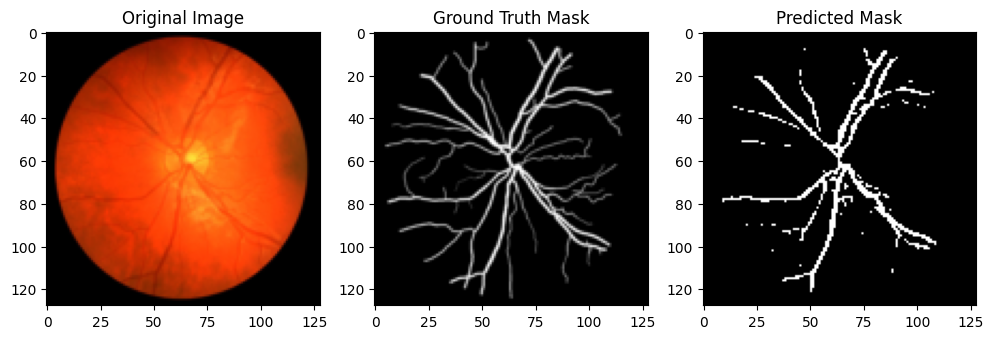

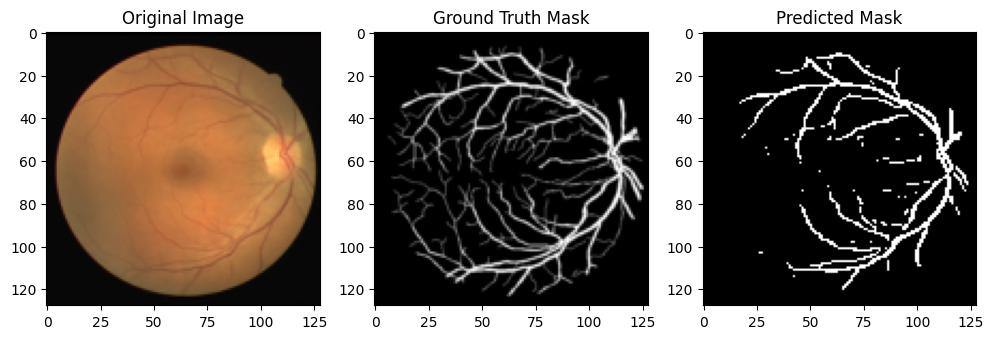

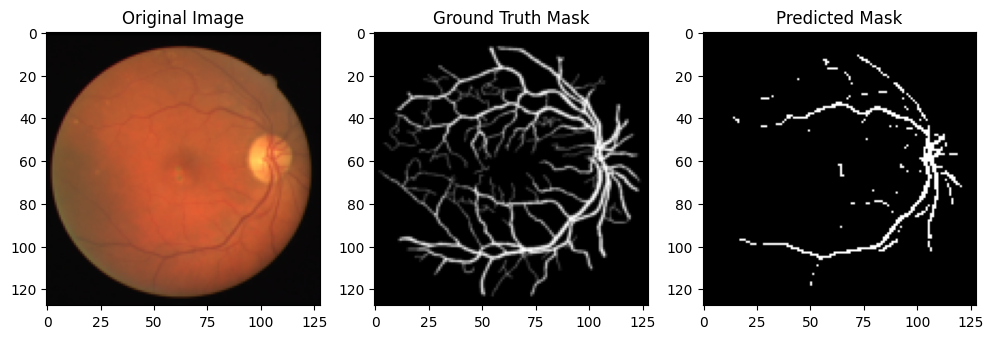

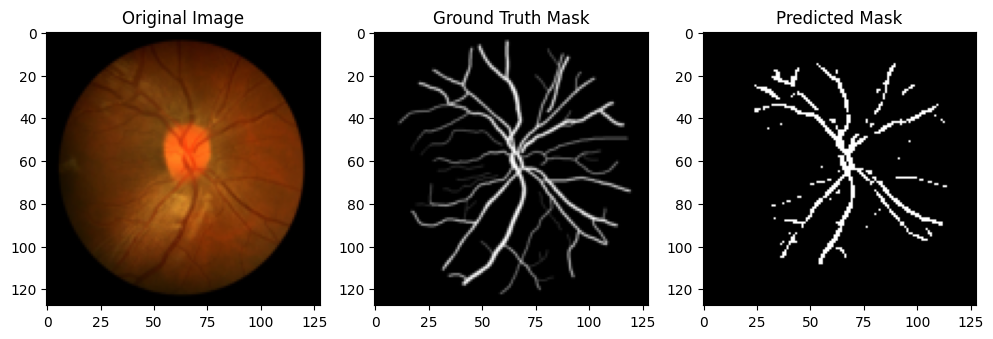

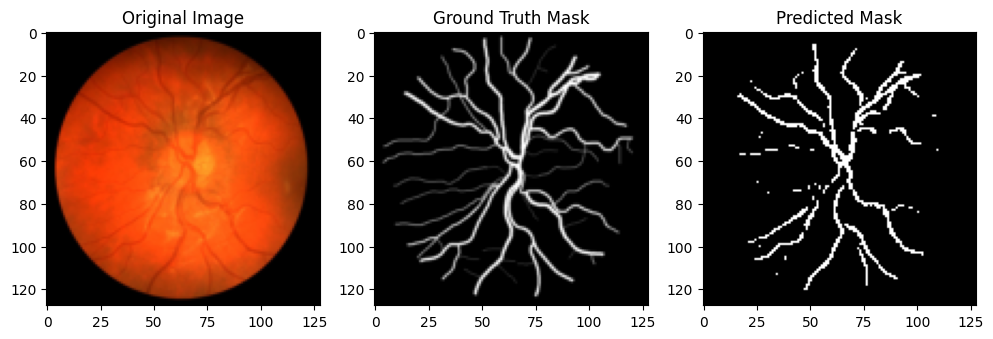

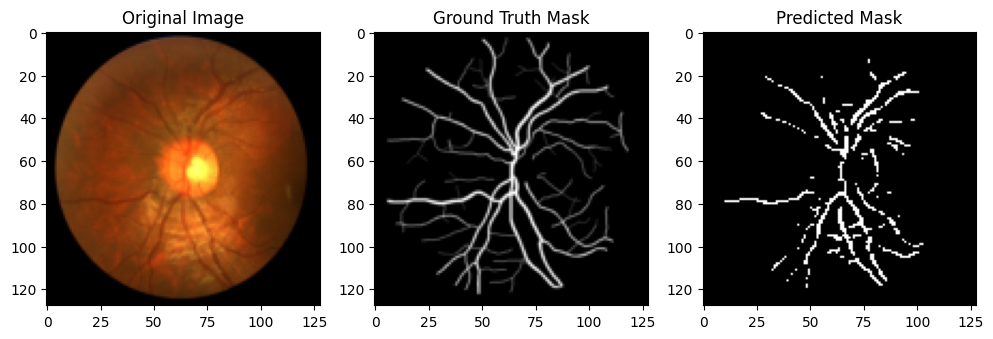

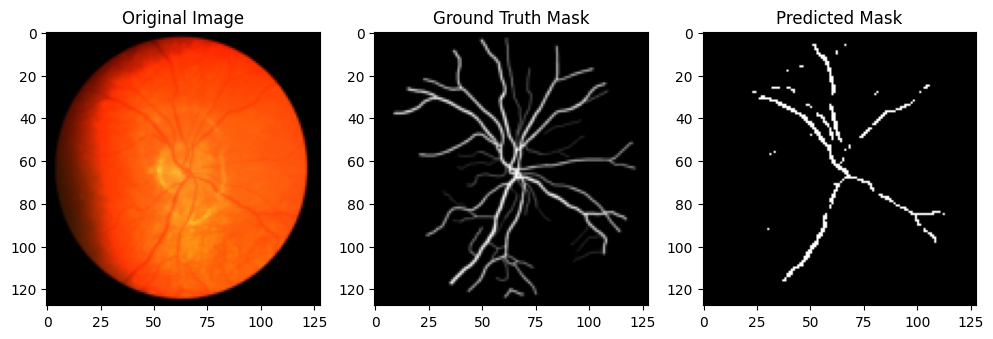

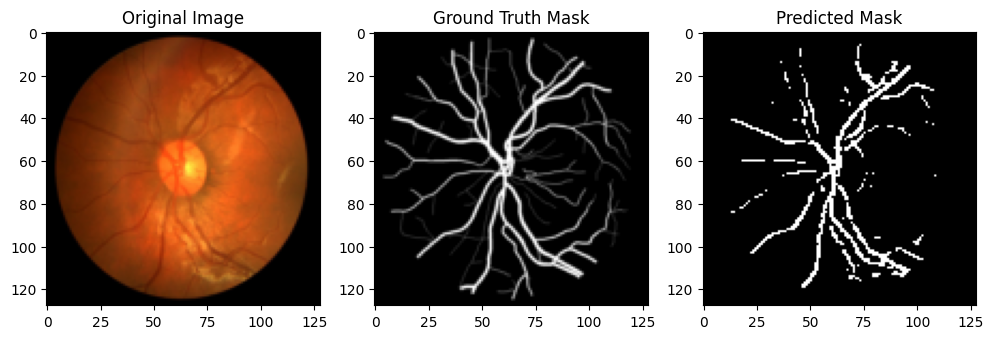

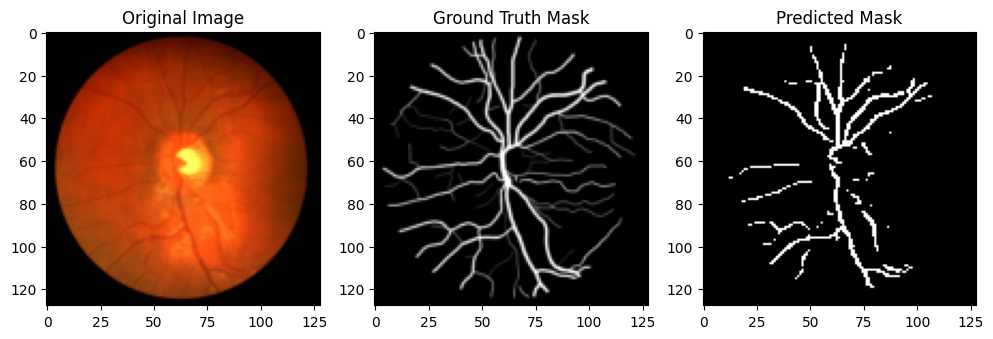

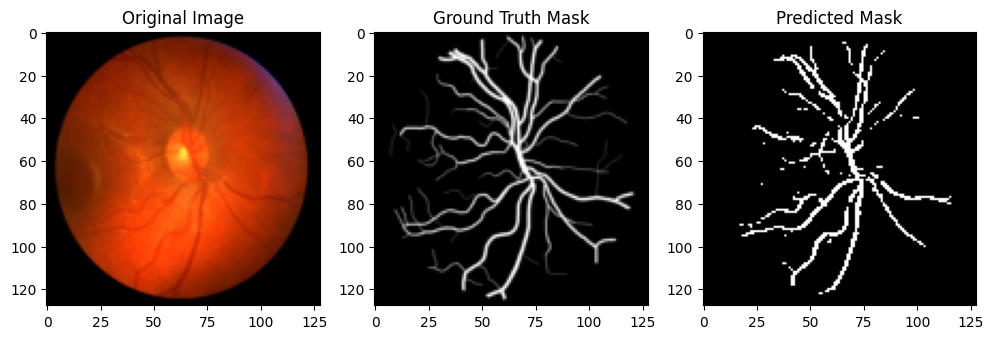

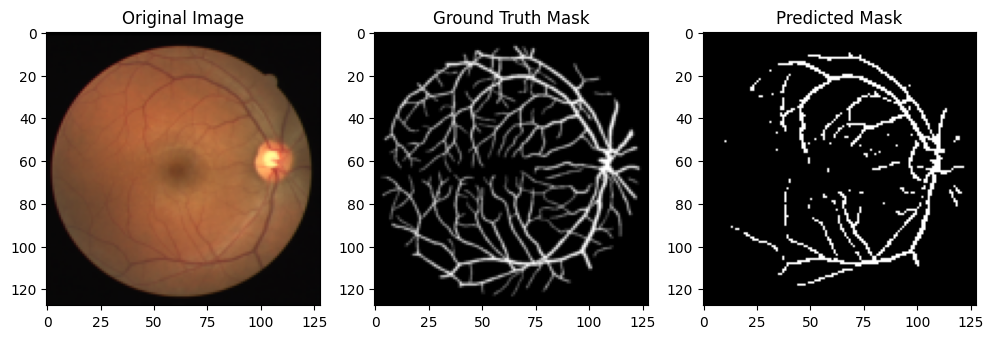

In [63]:
# Set the model to evaluation mode
model.eval()

# Iterate over the test dataset
for i in range(len(test_dataset)):
    # Get the test data and labels
    test_data, test_labels = test_dataset[i]

    # Move the tensors to the device
    test_image = test_data.to(device)
    test_mask = test_labels.to(device)

    # Make a prediction using the model
    with torch.no_grad():
        test_logits = model(test_image.unsqueeze(0))

    # Apply a sigmoid activation to the logits to get the segmentation mask
    test_pred = torch.sigmoid(test_logits)

    # Convert the predicted mask to a binary image
    test_pred_image = (test_pred > 0.5).float()

    # Visualize the original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(test_image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")

    axes[1].imshow(test_mask[0, :, :].cpu().numpy(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")

    axes[2].imshow(test_pred_image[0, 0, :, :].cpu().numpy(), cmap='gray')
    axes[2].set_title("Predicted Mask")

    plt.show()

    # Add a short delay to prevent the plots from closing too quickly
    plt.pause(0.5)